<a href="https://colab.research.google.com/github/tsuba03/tsuba03/blob/main/ml2023_04_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 演習4: 回帰分析

適切な題材を選び、回帰モデルを学習せよ。ただし、以下の観点で採点を行うので、これらを満たすように解答せよ。

## 1. タスクの説明

選んだ回帰分析タスクの概要（入力と出力が何であるか等）を説明せよ。
<!-- 04:01 -->

In [ ]:
'''
私が題材に選んだ回帰分析タスクは、出生数と出産入院料に関する回帰分析である。
入力が1カ月ごとの日本の出生数、出力が1カ月間の家計の出産入院料である。
これを題材に選んだのは、出生数と出産入院料（出産に関わる入院費用）には、
一見因果関係がありそうでだったので、共変関係が存在し、回帰分析を用いるのに適した題材ではないかと思ったからである。
'''

## 2. データの入手方法・構築方法

回帰分析を行う訓練データや評価データの入手方法を説明せよ。データを自作した場合は、作成方法を説明せよ。
<!-- 04:02 -->

In [233]:
'''
入力データは、厚生労働省が行っている人口動態調査の『人口動態統計 確定数 出生』の統計表、表題「出生月別にみた年次別出生数及び出生率（人口千対）」の2002年から2021年までの240個の出生数データを用いている。
出力データは、総務省統計局が発表している『家計消費状況調査』の2002年から2021年までの240個の「出産入院料」のデータを使用している。
これらを数値を変えずにCSVファイルで同じ年月でまとめてデータセットを作成した。

入力データ　https://www.e-stat.go.jp/dbview?sid=0003411596
出力データ　https://www.stat.go.jp/data/joukyou/12.html

タスクで使用するデータは、オーダーが大きく、異なるので、(X - X_min)/(X_max - X_min)で正規化した。
'''
import numpy as np
import matplotlib.pyplot as plt


all_data=np.loadtxt('/content/birth-cost-data.csv', delimiter=',')#データの読み込み

all_data_scaled = np.vstack([(all_data[:,0] - min(all_data[:,0]))/(max(all_data[:,0])-min(all_data[:,0])), (all_data[:,1] - min(all_data[:,1]))/(max(all_data[:,1])-min(all_data[:,1]))]).T#(X - X_min)/(X_max - X_min)で正規化


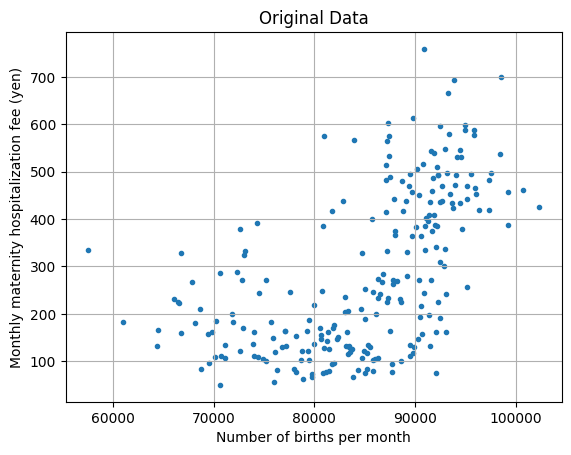

In [234]:
#元データの散布図
X = all_data[:,0]
Y = all_data[:,1]

plt.subplots(dpi=100)
plt.title('Original Data')
plt.xlabel('Number of births per month')
plt.ylabel('Monthly maternity hospitalization fee (yen)')
plt.grid()
plt.scatter(X, Y, marker='.')

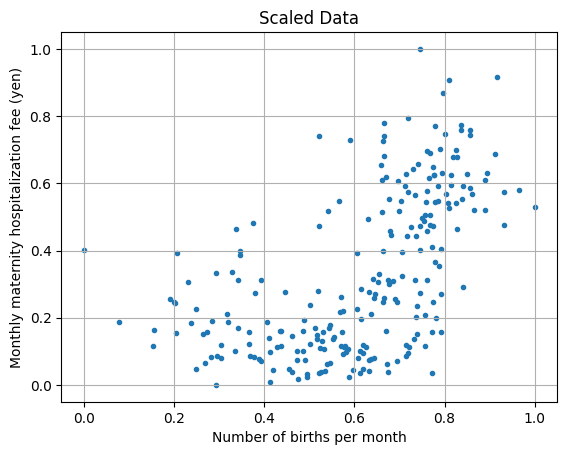

In [235]:
#正規化したデータの散布図
X = all_data_scaled[:,0]
Y = all_data_scaled[:,1]

plt.subplots(dpi=100)
plt.title('Scaled Data')
plt.xlabel('Number of births per month')
plt.ylabel('Monthly maternity hospitalization fee (yen)')
plt.grid()
plt.scatter(X, Y, marker='.')

In [236]:
'''
評価データには、全てのデータのうちランダムで選んだ48組（2割）のデータを使用し、訓練データはそのほかの192組のデータを利用する。
'''
# データをシャッフル
np.random.shuffle(all_data_scaled)

evaluate_rate = 0.2
size = len(all_data_scaled)
# データを分割: 2割をevaluate_dataに、残りをtrain_dataに
evaluate_data = all_data_scaled[:int(evaluate_rate*size)]
train_data = all_data_scaled[int(evaluate_rate*size):]

## 3. モデルの学習

訓練データで回帰モデルを確率的勾配降下法により学習せよ。このとき、各エポック毎に以下の評価値を計算し、グラフとして表示せよ。

+ 訓練データ上の損失関数の値
+ 評価データ上の損失関数の値
<!-- 04:03 -->

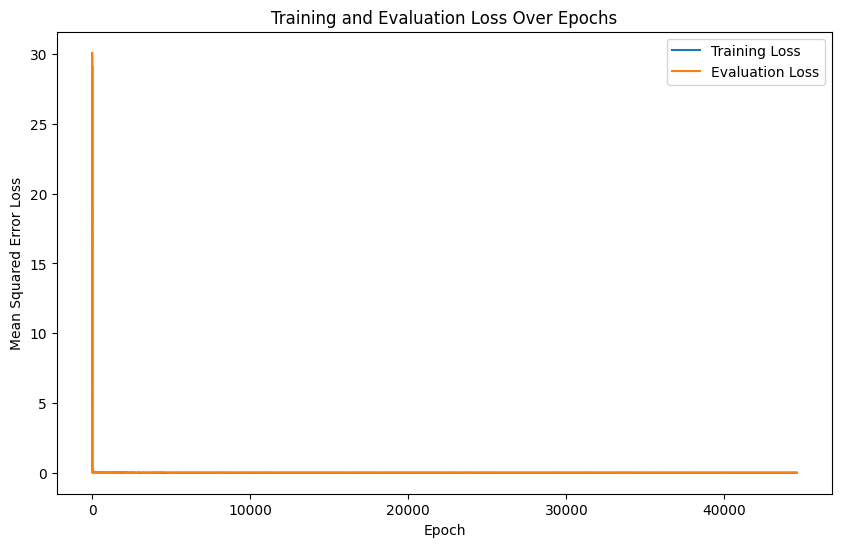

In [324]:
'''
オリジナルデータを見る限り、データの散らばりが放物線のように見えるので、2次関数を想定して学習を行う。
'''

import matplotlib.pyplot as plt

# 確率的勾配降下法のパラメータ
max_epochs = 50000
eta0 = 1.5
eps = 1e-5

# データの形式を調整
X_train = np.vstack([train_data[:,0]**2, train_data[:,0], np.ones_like(train_data[:,0])]).T
y_train = train_data[:,1]
X_eval = np.vstack([evaluate_data[:,0]**2,evaluate_data[:,0], np.ones_like(evaluate_data[:,0])]).T
y_eval = evaluate_data[:,1]

# 重みの初期化
w = np.zeros(X_train.shape[1])

# 損失関数の値を記録するリスト
train_loss = []
eval_loss = []

# 損失関数の定義
def mse_loss(X, y, weights):
    predictions = X.dot(weights)
    errors = predictions - y
    return np.mean(errors ** 2)

# 確率的勾配降下法の実行
for t in range(max_epochs):
    # 学習率の更新
    eta = eta0 / np.sqrt(1+t)
    # ランダムなデータ点を選択
    i = np.random.randint(0, X_train.shape[0])
    # 予測と勾配の計算
    y_hat = np.dot(X_train[i], w)
    grad = 2 * (y_hat - y_train[i]) * X_train[i]
    if np.sum(np.abs(grad)) < eps:
      break
    # 重みの更新
    w -= eta * grad
    # 損失関数の計算
    train_loss.append(mse_loss(X_train, y_train, w))
    eval_loss.append(mse_loss(X_eval, y_eval, w))

# 損失関数のグラフを描画
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Evaluation Loss')
plt.title('Training and Evaluation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

In [325]:
w

array([ 1.25900392, -0.70130772,  0.24245016])

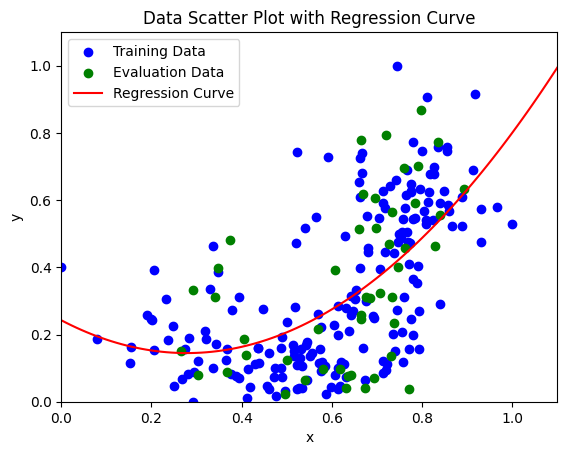

In [326]:
'''
求めたパラメータをもとに　回帰曲線をグラフにプロットすると以下のようになる
'''

# 2次関数の形式で予測値を計算するための関数
def predict(x, weights):
    return weights[0]*x**2 + weights[1]*x + weights[2]

# 訓練データと評価データのx値
x_train = train_data[:,0]
x_eval = evaluate_data[:,0]

x = np.linspace(0,1.1,100)

# 散布図と回帰曲線をプロット
fig, ax = plt.subplots(dpi=100)
ax.scatter(x_train, y_train, label='Training Data', color='blue')
ax.scatter(x_eval, y_eval, label='Evaluation Data', color='green')
ax.plot(x, predict(x, w), color='red', label='Regression Curve')
plt.title('Data Scatter Plot with Regression Curve')
plt.xlabel('x')
plt.ylabel('y')
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
plt.legend()
plt.show()

In [323]:
# 訓練データと評価データの予測値を計算
y_train_pred = predict(x_train, w)
y_eval_pred = predict(x_eval, w)

e_train = np.mean((y_train_pred - y_train) ** 2)
e_valid = np.mean((y_eval_pred - y_eval) ** 2)
print(f'MSR = {e_train:.10f} (training), {e_valid:.10f} (validation)')

MSR = 0.0302245234 (training), 0.0411342113 (validation)


## 4. 回帰分析から得られた知見

回帰分析から得られた知見をまとめよ。また、回帰モデルがうまく学習できなかった場合は、その原因を分析・考察せよ。
<!-- 04:04 -->

In [ ]:
'''
データそのものについて得られた知見として、2次関数でのフィッティングがある程度上手くいっているようにみえたことがある。
『家計消費状況調査』は、全国の家計の平均値を統計的に推定しているので、出生数が増えると出産入院料は増えることは自然であり、
回帰曲線もこの傾向を上手く表すことができていたと考える。一方、出生数が少なくなると、病院は入院料を増やし、収益の確保に
務めるので、入院費用も高くなる。この傾向は、実際に現在指摘されており、回帰曲線はこの傾向も表すことができていたと考える（NHK 2023）。

回帰分析そのものについて得られた知見としては、想像以上に上手く2次関数に当てはめることが難しかったことがある。
これは、アルゴリズム自体というよりデータの形式や更新幅などの設定が上手くできていなかったことが原因である。
データの形式は、初めそのままのデータで行おうとしていたが、オーバーフローが発生したので、オーダーを調整することで、
対応しようとしたが、一向に上手くいかず、最終的に正規化することで上手く調整することができた。
アルゴリズムに必要なパラメータについて、エポック数は、途中で更新幅が小さくなったときに打ち切るので、
十分大きな値をとっておくことで解決できたが、その打ち切りの幅と更新幅については、何度も調整を繰り返したが、
中々良い結果を得るのに時間がかかった。

参考文献：
NHK 『なぜ上がり続ける？出産費用』2023年9月26日 https://www.nhk.jp/p/ohayou/ts/QLP4RZ8ZY3/blog/bl/pzvl7wDPqn/bp/p1JeALXER3/（2024年1月9日最終閲覧）
'''

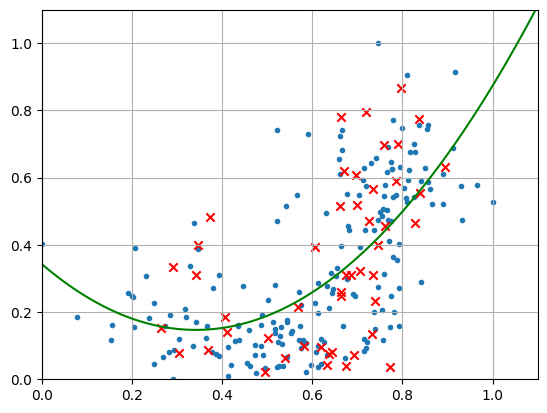

In [327]:
'''
授業内で扱ったnumpy.polynomialを用いるとどのような回帰分析を行うのか確認する。
若干確率的勾配降下法で求めた曲線と異なるように見える。
'''

from numpy.polynomial import Polynomial

X=train_data[:,0]
Y=train_data[:,1]

W = Polynomial.fit(X, Y, 2)
W.convert().coef

def plot_graph(X, Y, x, y, X_valid, Y_valid):
    fig, ax = plt.subplots(dpi=100)
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.grid()
    ax.scatter(X, Y, marker='.')
    ax.scatter(X_valid, Y_valid, label=r'Validation data', marker='x', color='r')
    ax.plot(x, y, 'g')

x = np.linspace(0, 1.1, 100)
y_hat = W(x)
X_valid = evaluate_data[:,0]
Y_valid = evaluate_data[:,1]
plot_graph(X, Y, x, y_hat, X_valid, Y_valid)

In [328]:
'''
以下を見るとハイパーパラメータとしては、2次より大きい6次関数がより適切であるようである。
'''

for d in range(1, 10):
    W = Polynomial.fit(X, Y, d)
    Y_hat = W(X)
    Y_valid_hat = W(X_valid)
    e_train = np.mean((Y_hat - Y) ** 2)
    e_valid = np.mean((Y_valid_hat - Y_valid) ** 2)
    print(f'd = {d}: MSR = {e_train:.10f} (training), {e_valid:.10f} (validation)')

d = 1: MSR = 0.0359206664 (training), 0.0452830749 (validation)
d = 2: MSR = 0.0298683542 (training), 0.0401704145 (validation)
d = 3: MSR = 0.0294252373 (training), 0.0409185614 (validation)
d = 4: MSR = 0.0284122032 (training), 0.0392485642 (validation)
d = 5: MSR = 0.0281684582 (training), 0.0383785516 (validation)
d = 6: MSR = 0.0281282785 (training), 0.0381000909 (validation)
d = 7: MSR = 0.0280614991 (training), 0.0383144854 (validation)
d = 8: MSR = 0.0280614654 (training), 0.0383209651 (validation)
d = 9: MSR = 0.0280499320 (training), 0.0383054436 (validation)


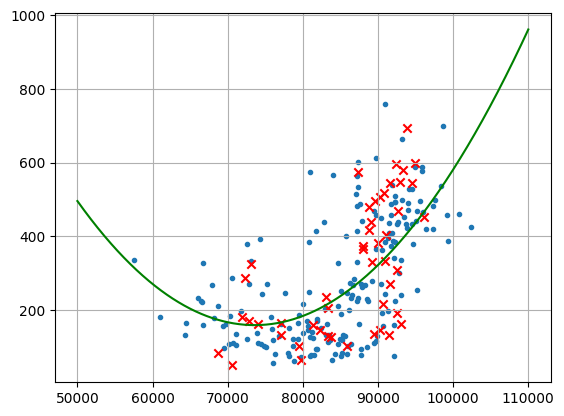

In [269]:
'''
元データから直接numpy.polynomialを用いて回帰分析を行った。
得られるグラフの形は、正規化したものと大差ないようである。
'''
np.random.shuffle(all_data)

evaluate_rate = 0.2
size = len(all_data)
evaluate_data_nsc = all_data[:int(evaluate_rate*size)]
train_data_nsc = all_data[int(evaluate_rate*size):]

X_nsc=train_data_nsc[:,0]
Y_nsc=train_data_nsc[:,1]

W = Polynomial.fit(X, Y, 2)
W.convert().coef

def plot_graph(X, Y, x, y, X_valid, Y_valid):
    fig, ax = plt.subplots(dpi=100)
    ax.grid()
    ax.scatter(X, Y, marker='.')
    ax.scatter(X_valid, Y_valid, label=r'Validation data', marker='x', color='r')
    ax.plot(x, y, 'g')

x = np.linspace(50000, 110000, 1000)
y_hat_nsc = W(x)
X_valid_nsc = evaluate_data_nsc[:,0]
Y_valid_nsc = evaluate_data_nsc[:,1]
plot_graph(X_nsc, Y_nsc, x, y_hat_nsc, X_valid_nsc, Y_valid_nsc)

In [270]:
for d in range(1, 10):
    W = Polynomial.fit(X, Y, d)
    Y_hat = W(X)
    Y_valid_hat = W(X_valid)
    e_train = np.mean((Y_hat - Y) ** 2)
    e_valid = np.mean((Y_valid_hat - Y_valid) ** 2)
    print(f'd = {d}: MSR = {e_train:.10f} (training), {e_valid:.10f} (validation)')

d = 1: MSR = 18620.5095456422 (training), 20781.5297880556 (validation)
d = 2: MSR = 15406.5754574007 (training), 18831.5061521117 (validation)
d = 3: MSR = 15303.8567475885 (training), 18603.2156530360 (validation)
d = 4: MSR = 14750.3269833197 (training), 17840.3135247423 (validation)
d = 5: MSR = 14548.2344056233 (training), 17731.0916123234 (validation)
d = 6: MSR = 14513.4212337278 (training), 17610.9170049187 (validation)
d = 7: MSR = 14494.0437690434 (training), 17643.3909744694 (validation)
d = 8: MSR = 14493.6734302737 (training), 17660.3825518221 (validation)
d = 9: MSR = 14489.9584612275 (training), 17654.9175396519 (validation)
